In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds


Mounted at /content/drive


In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

Dataset


In [ ]:
from keras.initializers import RandomNormal
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, Concatenate, Input, ReLU
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MAE

In [ ]:
import tensorflow_datasets as tfds
import os
from PIL import Image
import matplotlib.pyplot as plt

Generator


In [ ]:
def downsample(input,filters,size,batchnorm = True):
    #initializing the weights
    init = RandomNormal(0.,0.02)
    x = Conv2D(filters,size,strides = 2,padding = 'same',kernel_initializer = init,use_bias = False)(input)
    if batchnorm :
        x = BatchNormalization()(x,training= True)
    x = LeakyReLU(0.2)(x)

    return x

In [ ]:
def upsample(input,skip_block,filters,size,dropout = True):
    #initializing the weights
    init = RandomNormal(0.,0.02)
    x = Conv2DTranspose(filters,size,strides = 2,padding = 'same',kernel_initializer = init,use_bias = False)(input)
    x = BatchNormalization()(x,training = True)
    if dropout :
        x = Dropout(0.5)(x,training = True)
    x = Concatenate()([x,skip_block])
    x = ReLU()(x)
    return x

In [ ]:
def Generator(image_shape = (256,256,3)):
    model = Sequential()
    #initializing the weights
    init = RandomNormal(0.,0.02)
    input = Input(shape = image_shape)

    d1 = downsample(input,64,4,batchnorm = False)
    d2 = downsample(d1,128,4)
    d3 = downsample(d2,256,4)
    d4 = downsample(d3,512,4)
    d5 = downsample(d4,512,4)
    d6 = downsample(d5,512,4)
    d7 = downsample(d6,512,4)

    bottleneck = Conv2D(512,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(d7)
    bottleneck = ReLU()(bottleneck)

    u1 = upsample(bottleneck,d7,512,4)
    u2 = upsample(u1,d6,512,4)
    u3 = upsample(u2,d5,512,4)
    u4 = upsample(u3,d4,512,4,dropout = False)
    u5 = upsample(u4,d3,256,4,dropout = False)
    u6 = upsample(u5,d2,128,4,dropout = False)
    u7 = upsample(u6,d1,64,4,dropout = False)

    output = Conv2DTranspose(3,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init,activation='tanh')(u7)

    model = Model(input,output)

    return model


In [ ]:
image_shape = (256,256,3)
Generator = Generator(image_shape)
Generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


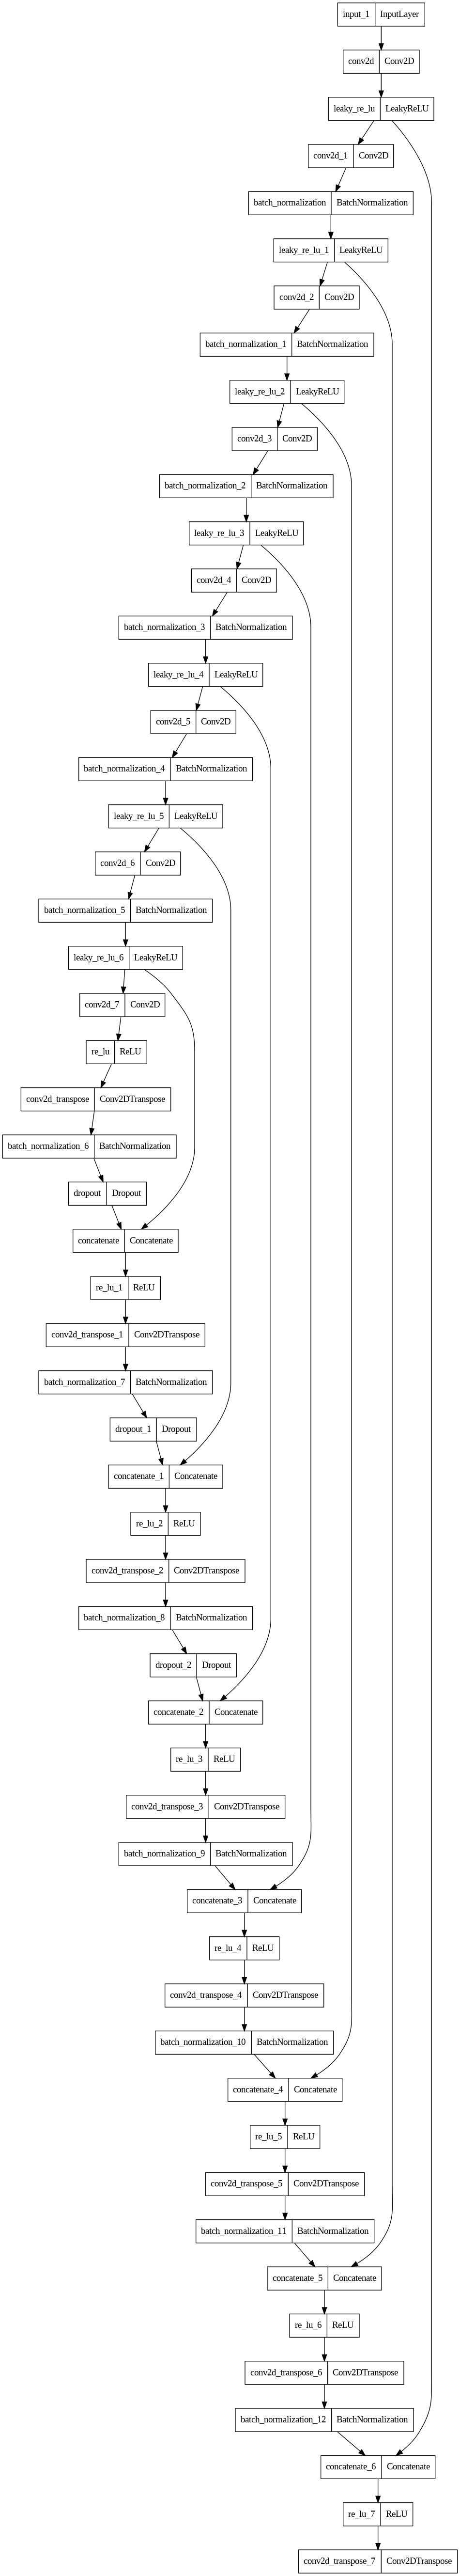

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(Generator)

In [ ]:
import numpy as np

In [ ]:
path = '<Path of a Specific image to display it >'
path_ = '<Path of a Specific image to display it>'
img_out = Image.open(path_)
img_out = img_out.resize((256,256))
img_inp = Image.open(path)
img_inp = img_inp.resize((256,256))
img = np.asarray(img_inp)/255
img = np.expand_dims(img,axis = 0)
img = Generator.predict(img)*256
img = img.reshape(256,256,3)
img = img*255

1/1 [==============================] - 0s 35ms/step


In [ ]:
import matplotlib.pyplot as plt

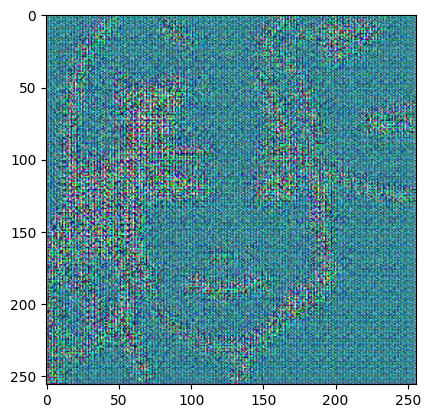

In [ ]:
p = '<Path of a Specific image to display it >'
img = np.asarray(Image.open(p))

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Discriminator

In [ ]:
def Discriminator(image_shape):
    #initializing the weights
    init = RandomNormal(0.,0.02)

    src_img = Input(image_shape)
    tar_img = Input(image_shape)

    input = Concatenate()([src_img,tar_img])

    x = Conv2D(64,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(input)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512,(4,4),strides = (1,1),padding = 'same',kernel_initializer = init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512,(4,4),strides = (2,2),padding = 'same',kernel_initializer = init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    patch = Conv2D(1,(4,4),strides = 1,padding = 'same',kernel_initializer = init,activation = 'sigmoid')(x)
    model = Model([src_img,tar_img],patch)

    return model


In [ ]:
image_shape = (256,256,3)
Discriminator = Discriminator(image_shape)
Discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
#Discriminator.predict((x,pred)).shape

In [ ]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(lr = 0.0002,beta_1 = 0.5)
d_opt = Adam(lr = 0.0002,beta_1 = 0.5)

g_loss = BinaryCrossentropy([1])
d_loss = BinaryCrossentropy([0.5])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
class Pix2Pix(Model):
    def __init__(self,Generator,Discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)

        self.Generator = Generator
        self.Discriminator = Discriminator

    def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
        super().compile(*args,**kwargs)

        # Initiating losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,batch):
        self.src_img = batch[0][0]
        self.tar_img = batch[0][1]
        target_images =  self.tar_img
        generated_images = self.Generator(self.src_img,training = False)
        source_images = self.src_img

        # Trainig the discriminator

        with tf.GradientTape() as d_tape:
            disc_real = self.Discriminator([source_images,target_images],training = True)
            disc_generated = self.Discriminator([source_images,generated_images],training = True)

            disc_real_loss = self.d_loss(tf.ones_like(disc_real),disc_real)
            disc_generated_loss = self.d_loss(tf.zeros_like(disc_generated),disc_generated)

            disc_loss = disc_real_loss + disc_generated_loss

        # Backpropogation
        dgrad = d_tape.gradient(disc_loss,self.Discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.Discriminator.trainable_variables))

         # Training the generator

        with tf.GradientTape() as g_tape:
            #generated_output = generated_images

            generator_loss = self.g_loss(tf.ones_like(disc_generated),disc_generated)

            l1_loss = tf.reduce_mean(tf.abs(target_images - generated_images))

            total_gen_loss = generator_loss + (100*l1_loss)

        ggrad = g_tape.gradient(total_gen_loss,self.Generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.Generator.trainable_variables))

        return {"d_loss " : disc_loss, "g_loss" : total_gen_loss}


In [ ]:
GAN = Pix2Pix(Generator,Discriminator)
GAN.compile(g_opt,d_opt,g_loss,d_loss)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self,num_img = 4, latent_dim =128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self,epoch, logs = None):
        random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
          img = array_to_img(generated_images[i])
          img.save(f"Generated_img_{epoch}_{i}.png")

In [ ]:
hist = GAN.fit(train_data,epochs = 10,validation_data = val_data ,callbacks = [ModelMonitor()])